In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.preprocessing import MultiLabelBinarizer

from multiprocessing import Pool
import soundfile as sf
import os


In [2]:
DEV_ROOT = './Data/FSD50K.dev_audio/'
TEST_ROOT = './Data/FSD50K.eval_audio/'

raw_dev_df = pd.read_csv('./Data/FSD50K.ground_truth/dev.csv', dtype={'fname': 'string'})

train_df = raw_dev_df[raw_dev_df['split'] == 'train'].drop(columns=['split']).copy()
val_df = raw_dev_df[raw_dev_df['split'] == 'val'].drop(columns=['split']).copy()
test_df = pd.read_csv('./Data/FSD50K.ground_truth/eval.csv', dtype={'fname': 'string'})
vocab_df = pd.read_csv('./Data/FSD50K.ground_truth/vocabulary.csv', index_col=0, header=None, names=['label','mids'])
vocab_dict = dict(zip(vocab_df.mids, vocab_df.label))

In [3]:
train_df.head()

,fname,labels,mids
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"


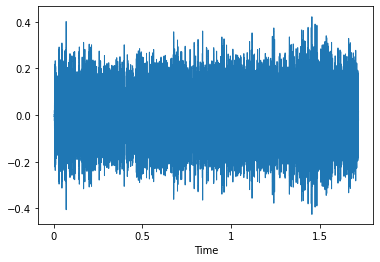

In [4]:
sample_file = DEV_ROOT + train_df.fname[0] + '.wav'
data, sample_rate = librosa.load(sample_file, sr = None)
librosa.display.waveshow(data,sr = sample_rate)
ipd.Audio(sample_file)

>The Nyquist–Shannon sampling theorem says the sampling frequency must be greater than twice the maximum frequency one wishes to reproduce. 

In [5]:
print(f'Sample rate: {sample_rate}')
print(f'Audio Length: {len(data)/sample_rate}s')

Sample rate: 44100
Audio Length: 1.7143083900226757s


### EDA

In [6]:
def audio_adder(filename):
    audio_file = DEV_ROOT + filename + '.wav'
    data, sample_rate = librosa.load(audio_file, sr = None)
    return(len(data)/sample_rate)

_Extracting file length takes a while because i/o_

In [7]:
# train_df['length'] = train_df['fname'].apply(lambda x: audio_adder(x))
# val_df['length'] = val_df['fname'].apply(lambda x: audio_adder(x))

In [8]:
train_df

,fname,labels,mids
0,64760,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
1,16399,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
2,16401,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
3,16402,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
4,16404,"Electric_guitar,Guitar,Plucked_string_instrume...","/m/02sgy,/m/0342h,/m/0fx80y,/m/04szw,/m/04rlf"
...,...,...,...
40961,102863,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk"
40962,389607,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk"
40963,90091,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk"
40964,244718,"Fowl,Livestock_and_farm_animals_and_working_an...","/m/025rv6n,/m/0ch8v,/m/0jbk"


### Pre-processing for training

In [9]:
# def label_onehot_processor(df):
#     '''
#     Onehot encodes mids and removes labels
#     '''
#     df.drop(columns=['labels'], inplace=True)
#     df['mids'] = df['mids'].apply(lambda x: tuple(x.split(',')))
#     df = df.join(pd.DataFrame(one_hot_encoder.fit_transform(df.pop('mids')),
#                           columns=one_hot_encoder.classes_,
#                           index=df.index))
#     return df

In [10]:
# train_df = label_onehot_processor(train_df)
# val_df = label_onehot_processor(val_df)
# test_df = label_onehot_processor(test_df)

In [11]:
one_hot_encoder = MultiLabelBinarizer()
train_df['mids'] = train_df['mids'].apply(lambda x: tuple(x.split(',')))
val_df['mids'] = val_df['mids'].apply(lambda x: tuple(x.split(',')))
test_df['mids'] = test_df['mids'].apply(lambda x: tuple(x.split(',')))
one_hot_encoder.fit(train_df['mids'])

MultiLabelBinarizer()

In [12]:
train_label_vector = one_hot_encoder.transform(train_df['mids'])
val_label_vector = one_hot_encoder.transform(val_df['mids'])
test_label_vector = one_hot_encoder.transform(train_df['mids'])
label_mids_classes = one_hot_encoder.classes_
print("train_label_vector shape: " + ' x '.join(str(v) for v in train_label_vector.shape))
print("val_label_vector shape: " + ' x '.join(str(v) for v in val_label_vector.shape))
print("test_label_vector shape: " + ' x '.join(str(v) for v in test_label_vector.shape))
print("Number of Classes: " + str(len(label_mids_classes)))

train_label_vector shape: 36796 x 200
val_label_vector shape: 4170 x 200
test_label_vector shape: 36796 x 200
Number of Classes: 200


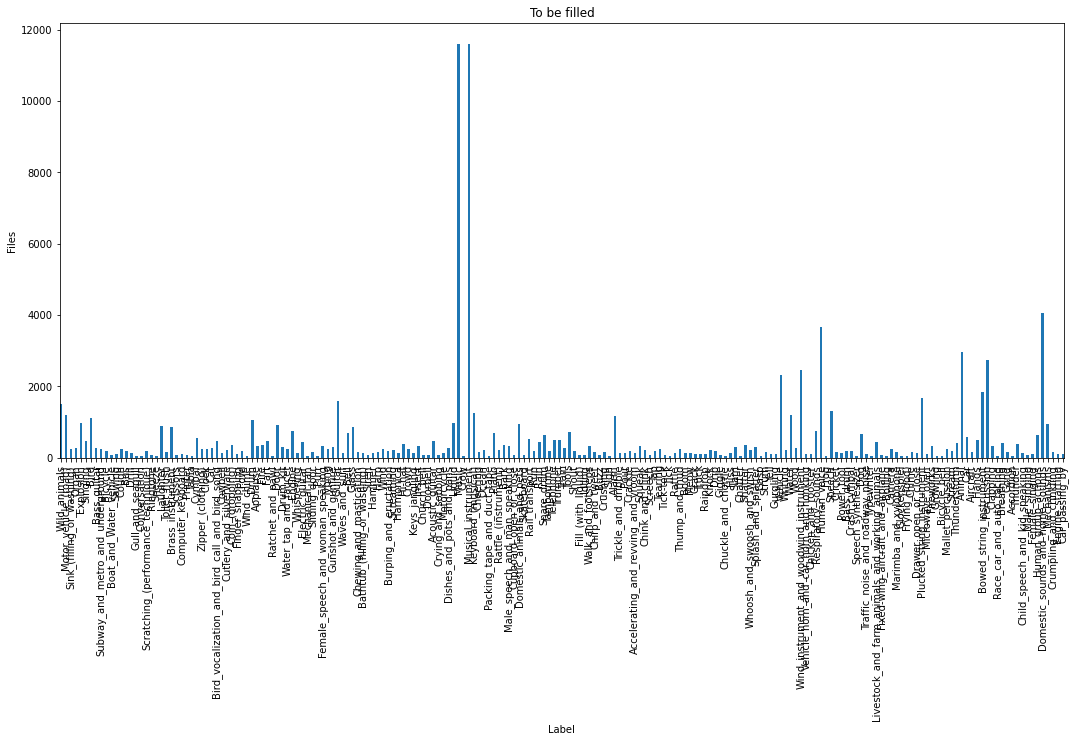

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (18, 8))
plt.bar([vocab_dict[i] for i in label_mids_classes], 
        np.sum(train_label_vector, axis=0),width=0.5)
plt.xlabel("Label")
plt.ylabel("Files")
plt.xticks(rotation='vertical')
plt.title("To be filled")
plt.margins(x=0)
plt.show()

#### Input chunking for fixed length mfcc conversion

In [14]:
# temporary files list, change to use dataframe later
files_list = ['63','699']
lf = len(files_list)

In [15]:
def replicate(data, min_clip_len):
  if len(data) < min_clip_len:
    tile_size = (min_clip_len // data.shape[0]) + 1
    data = np.tile(data, tile_size)[:min_clip_len]
  return data

In [16]:
# Saving so that we only need to do this once
PARTS_DIR = './Data/Chunks/'
def process_idx(idx):
  # print("in pool: "+str(idx))
  # return idx
  file_name = files_list[idx]
  file_path = DEV_ROOT + file_name + '.wav'
  data, sample_rate = librosa.load(file_path)
  min_clip_len = int(sample_rate * 1)
  parts = []
  if len(data) < min_clip_len:
    data = replicate(data, min_clip_len)
    parts.append(data)
  else:
    overlap = int(sample_rate * 0.5) # 50% overlap
    for ix in range(0, len(data), overlap):
      clip_ix = data[ix:ix+min_clip_len]
      clip_ix = replicate(clip_ix, min_clip_len)
      parts.append(clip_ix)

  for i in range(len(parts)):
    path = os.path.join(PARTS_DIR, "{}_{:04d}.wav".format(file_name, i))
    sf.write(path, parts[i], sample_rate, "PCM_16")


In [ ]:
# Multithreaded processing to process multiple files at the same time
pool = Pool(24)
o = pool.map_async(process_idx, range(lf))
res = o.get()
pool.close()
pool.join()